In [1]:
import torch
from torch.utils.data.dataset import Dataset
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [2]:
#* Importing dataset
dataset_train = pd.read_csv('../data/train.csv')
dataset_test = pd.read_csv('../data/test.csv')
print('Training data length:', len(dataset_train))

Training data length: 42000


Training Features Shape (33600, 784)
Training Labels Shape (33600,)
Testing Features Shape (8400, 784)
Testing Labels Shape (8400,)


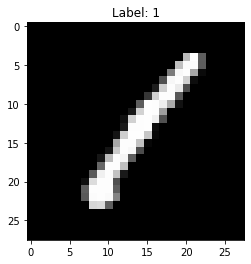

In [3]:
#* Having a look at the dataset
targets_np = dataset_train.label.values
features_np = dataset_train.loc[:,dataset_train.columns!='label'].values # values range to 255, so to normalize
X_train, X_test, y_train, y_test = train_test_split(features_np,targets_np,test_size=0.2, random_state=42)
#features_train = torch.from_numpy(X_train)
#target_train = torch.from_numpy(y_train)
#features_test = torch.from_numpy(X_test)
#target_test = torch.from_numpy(y_test)
print('Training Features Shape',X_train.shape)
print('Training Labels Shape',y_train.shape)
print('Testing Features Shape',X_test.shape)
print('Testing Labels Shape',y_test.shape)
#Viz of an image
plt.imshow(features_np[0].reshape(28,28),cmap='gray') # images are 28x28
plt.title('Label: '+str(targets_np[0]))
plt.show()

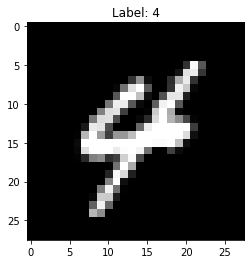

In [4]:
i=100
plt.imshow(X_test[i].reshape(28,28),cmap='gray') # images are 28x28
plt.title('Label: '+str(y_test[i]))
plt.show()

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt

def get_default_device():
    """Returns the default Device (cuda if gpu, else cpu"""
    if torch.cuda.is_available(): return torch.device('cuda')
    else: torch.device('cpu')

def to_device(data,device):
    """Shifts Data to the input device"""
    if isinstance(data,(list,tuple)): return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():

    def __init__(self, dl, device) -> None:
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    
    def __len__(self): return len(self.dl)


#* Creating a custom dataset overriding torchvision dataset
class MyDataset(Dataset):
    def __init__(self, df_features, df_labels, transform=None) -> None:
        self.features = df_features
        self.labels = df_labels
        self.transform = transform
    
    def __getitem__(self, index):
        data = self.features[index]
        image = data.reshape(28,28).astype(np.uint8)
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return (image,label)

    def __len__(self): return len(self.features)

BATCH_SIZE = 16

#* Augmentation - Random affination (rotation with translation), normalization
train_tmfs = tt.Compose([
    tt.ToPILImage(),
    #tt.RandomRotation(30), 
    tt.RandomAffine(degrees=30, translate = (0.1,0.1), scale = (0.9,1.1)),
    # Random Affine suits better for this purpose @https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#randomaffine
    tt.ToTensor(),
    tt.Normalize(mean=[features_np.mean()/255], std=[features_np.std()/255],inplace=True)
])
test_tmfs = tt.Compose([
    tt.ToPILImage(),
    #tt.RandomRotation(30),
    tt.RandomAffine(degrees=30, translate = (0.1,0.1), scale = (0.9,1.1)),
    # Random Affine suits better for this purpose @https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#randomaffine
    tt.ToTensor(),
    tt.Normalize(mean=[features_np.mean()/255], std=[features_np.std()/255],inplace=True)
])

#* Setting default Device, GPU
device = get_default_device()
print(device)

#* Creating Dataset
train_set = MyDataset(X_train, y_train, transform=train_tmfs)
test_set = MyDataset(X_test, y_test, transform=test_tmfs)

#* Loading data and then shifting data loader to the selected device
train_dl = DeviceDataLoader(DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True),device)
test_dl = DeviceDataLoader(DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True),device)

cuda


torch.Size([16, 1, 28, 28])
Label: tensor(7, device='cuda:0')


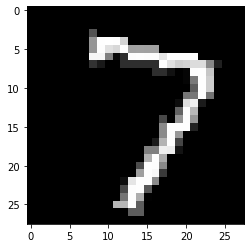

In [6]:
#* Sanity Check
imgs, lbls = next(iter(test_dl))
print(imgs.shape)
plt.imshow(torch.Tensor.cpu(imgs[0].data.reshape(28,28)),cmap='gray')
print('Label:',lbls[0])
plt.show()

In [7]:
import torch.nn.functional as F
#* Following Residual Network https://raw.githubusercontent.com/lambdal/cifar10-fast/master/net.svg
NUM_CLASSES = 10 

def convolution_block(in_channels, out_channels, pool=False):
    """Returns a sequence of Convolution, Batch Normalization, Rectified Linear Activation (Relu) and Max Pooling if selected"""
    layers = [
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
    if pool: layers.append(nn.MaxPool2d(2,2)) # 2x2 Max Pooling
    return nn.Sequential(*layers)

class Model(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = convolution_block(1,32)
        
        self.conv2 = convolution_block(32,64,pool=True)
        self.res1 = nn.Sequential(convolution_block(64,64), convolution_block(64,64))
        
        self.conv3 = convolution_block(64,128, pool=True)

        self.conv4 = convolution_block(128,256, pool=True)
        self.res2 = nn.Sequential(convolution_block(256,256), convolution_block(256,256))

        self.classifier = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.2), #* added later
            nn.Linear(256, NUM_CLASSES)
        )
    
    def forward(self, xb):
        out = self.conv1(xb) # Prep
        out = self.conv2(out) # Layer 1 Convolution Block
        out = self.res1(out) + out # Layer 1 Residual Block
        out = self.conv3(out) # Layer 2
        out = self.conv4(out) # Layer 3 Convolution Block
        out = self.res2(out) + out # Layer 3 Residual Block
        out = self.classifier(out)
        return F.log_softmax(out, dim=1)

In [8]:
model = Model()
to_device(model,device)

Model(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )


In [9]:
# Sanity Check
for images, labels in train_dl:
    print(images.shape)
    out = model(images)
    print(out.shape)
    break

torch.Size([16, 1, 28, 28])
C:\Users\Manan Biyani\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
torch.Size([16, 10])


In [10]:
'''
Cant find fastai modules
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy
'''

'\nCant find fastai modules\nfrom fastai.basic_data import DataBunch\nfrom fastai.train import Learner\nfrom fastai.metrics import accuracy\n'

In [11]:
import time
@torch.no_grad()
def loss_batch(model, loss_func, xb,yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_func(preds,yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)

    return loss.item(), len(xb), metric_result


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_dl, test_dl, 
                    weight_decay = 0, grad_clip = None, opt_func = torch.optim.SGD):

    def evaluate(model, test_dl):
        model.eval()
        outputs = [validation_step(images.to(device),labels.to(device)) for images, labels in test_dl]
        return validation_epoch_end(outputs)

    def training_step(images, labels):
        out = model(images)
        loss = F.cross_entropy(out,labels)
        return loss

    def validation_step(images, labels):
        out = model(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc':acc}
    
    def validation_epoch_end(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_losses = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_losses.item(), 'val_acc':epoch_acc.item()}
    
    def epoch_end(epoch, result, start_time):
        print("Epoch [{}], last_lr:{:.5f}, train_loss:{:.4f}, val_loss:{:.4f}, val_acc: {:.4f}, epoch_time:{:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc'], time.time()-start_time
        ))

    torch.cuda.empty_cache()
    results = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                            steps_per_epoch=len(train_dl))

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        train_losses = []
        lrs = [] # Learning rates at each point
        #* Training Part
        for batch in train_dl:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            
            loss = training_step(images, labels) # Generate Predictions and Calculate the loss
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step() # Compute Gradients
            optimizer.zero_grad() # Reset to zero

            lrs.append(get_lr(optimizer))
            scheduler.step()
        
        #* Validation part
        result = evaluate(model, train_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(epoch, result, epoch_start_time)
        results.append(result)
    
    return results

In [12]:
EPOCHS = 10
MAX_LEARNING_RATE = 0.001
GRAD_CLIP = 0.1
WEIGHT_DECAY = 1e-4
OPT_FUNC = torch.optim.Adam

In [13]:
results = []
results += fit_one_cycle(EPOCHS, MAX_LEARNING_RATE, model, train_dl, test_dl, WEIGHT_DECAY, GRAD_CLIP, OPT_FUNC)

Epoch [0], last_lr:0.00028, train_loss:0.4179, val_loss:0.1548, val_acc: 0.9515, epoch_time:49.2047
Epoch [1], last_lr:0.00076, train_loss:0.1639, val_loss:0.1181, val_acc: 0.9621, epoch_time:46.2490
Epoch [2], last_lr:0.00100, train_loss:0.1338, val_loss:0.1241, val_acc: 0.9604, epoch_time:46.5165
Epoch [3], last_lr:0.00095, train_loss:0.1064, val_loss:0.0702, val_acc: 0.9789, epoch_time:46.5150
Epoch [4], last_lr:0.00081, train_loss:0.0927, val_loss:0.0829, val_acc: 0.9734, epoch_time:51.5488
Epoch [5], last_lr:0.00061, train_loss:0.0753, val_loss:0.0676, val_acc: 0.9791, epoch_time:46.2106
Epoch [6], last_lr:0.00039, train_loss:0.0640, val_loss:0.0383, val_acc: 0.9886, epoch_time:45.8980
Epoch [7], last_lr:0.00019, train_loss:0.0448, val_loss:0.0307, val_acc: 0.9906, epoch_time:45.7560
Epoch [8], last_lr:0.00005, train_loss:0.0339, val_loss:0.0227, val_acc: 0.9929, epoch_time:46.0648
Epoch [9], last_lr:0.00000, train_loss:0.0255, val_loss:0.0209, val_acc: 0.9941, epoch_time:46.1152


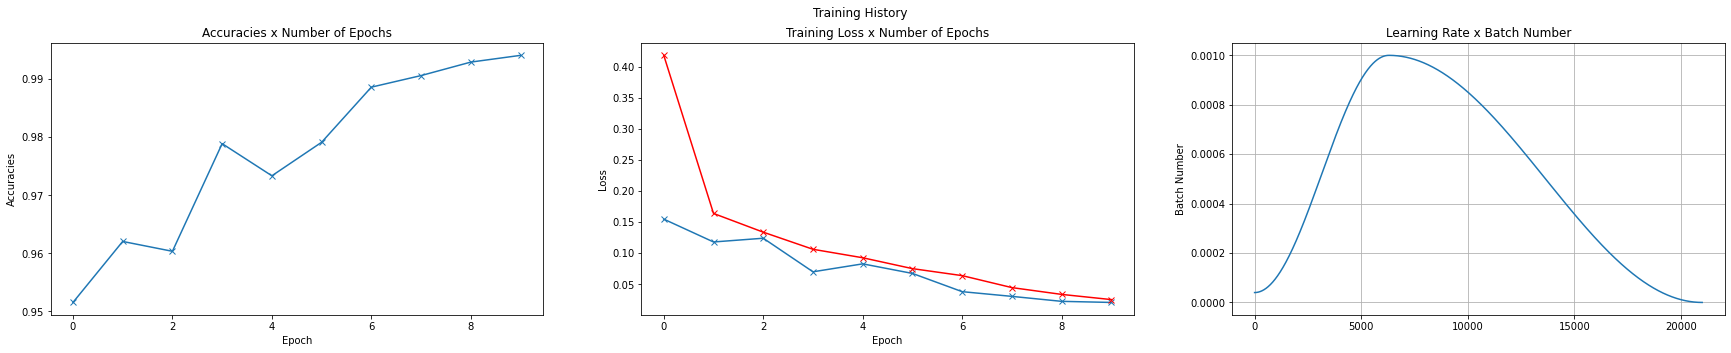

In [14]:
#* Plotting training history
time_taken = '8:19'
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(30,5))
accuracies = [x['val_acc'] for x in results]
axs[0].plot(accuracies, '-x')
axs[0].title.set_text('Accuracies x Number of Epochs')
axs[0].set_ylabel('Accuracies')
axs[0].set_xlabel('Epoch')
axs[1].plot([x['val_loss'] for x in results], '-x')
axs[1].title.set_text('Loss x Number of Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].plot([x['train_loss'] for x in results], '-rx')
axs[1].title.set_text('Training Loss x Number of Epochs')
lrs = np.concatenate([x.get('lrs',[]) for x in results])
axs[2].plot(lrs)
axs[2].title.set_text('Learning Rate x Batch Number')
axs[2].set_ylabel('Learning Rate')
axs[2].set_ylabel('Batch Number')
plt.suptitle('Training History')
plt.grid()
plt.show()

In [15]:
# Normalizing testing images
def normalize_test(X_test):
    X_test = X_test.reshape([-1,28,28]).astype(float)/255
    X_test = (X_test-features_np.mean())/features_np.std()
    return X_test
X_test = normalize_test(X_test)
# expanding dimension of test
X_test = np.expand_dims(X_test,axis=1)
X_test = torch.from_numpy(X_test).float().to(device)

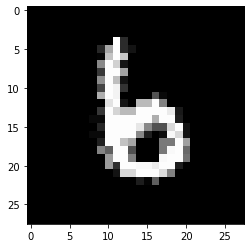

Prediction 6


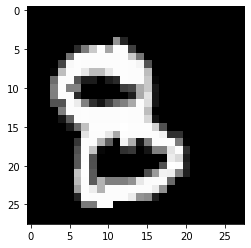

Prediction 8


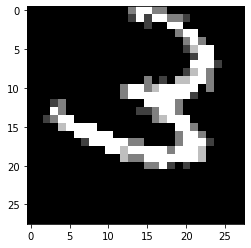

Prediction 3


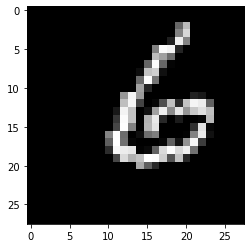

Prediction 6


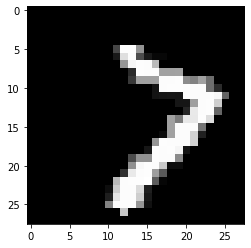

Prediction 7


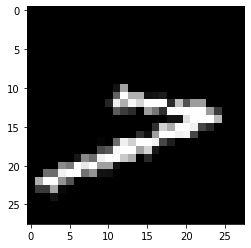

Prediction 7


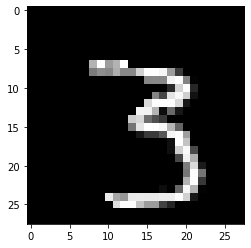

Prediction 3


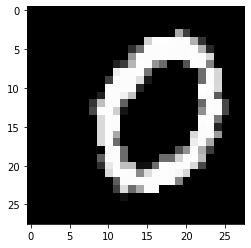

Prediction 0


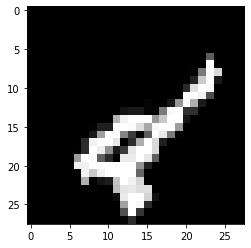

Prediction 4


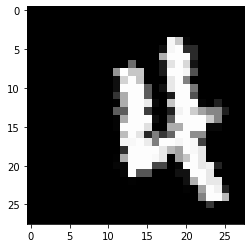

Prediction 4


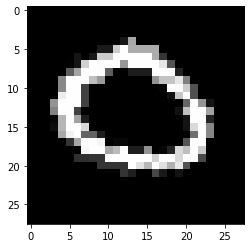

Prediction 0


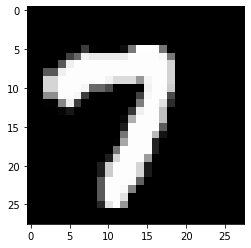

Prediction 7


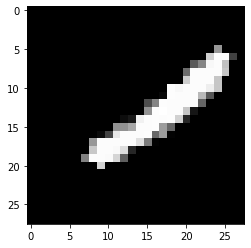

Prediction 1


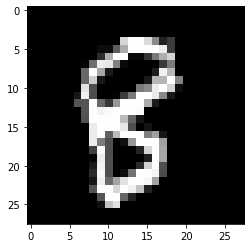

Prediction 8


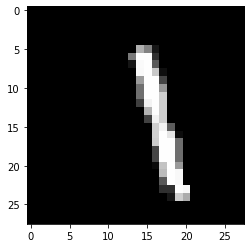

Prediction 1


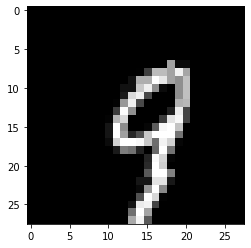

Prediction 9


In [16]:
# Testing some images, sanity checkk
for img, lbl in test_dl:
    ttt=img,lbl
    for i in range(BATCH_SIZE):
        plt.imshow(torch.Tensor.cpu(ttt[0][i].data.reshape(28,28)),cmap='gray')
        plt.show()
        print('Prediction',torch.argmax(model(ttt[0][i].unsqueeze(0)),1).item())
    break
# Seems to working :)

In [17]:
#* Prepping submission file
submission_np = dataset_test.values
class SubmissionDataset(Dataset):
    def __init__(self, df, transform=None) -> None:
        self.features = df
        self.transform = transform
    
    def __getitem__(self, index):
        data = self.features[index]
        image = data.reshape(28,28).astype(np.uint8)
        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self): return len(self.features)

submission_tmfs = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(mean=[features_np.mean()/255], std=[features_np.std()/255],inplace=True)
])

submission_set = SubmissionDataset(submission_np,transform=submission_tmfs)
submission_dl = DeviceDataLoader(DataLoader(submission_set, batch_size=1, shuffle=False),device)

torch.Size([1, 28, 28])


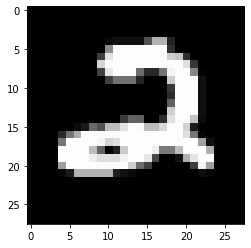

Prediction 2
torch.Size([1, 28, 28])


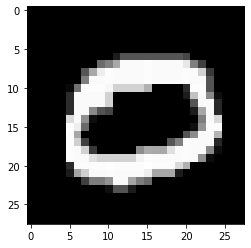

Prediction 0
torch.Size([1, 28, 28])


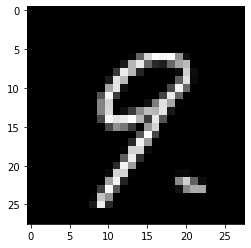

Prediction 9


In [18]:
#* Checking image by image in submission set
ctr=0
for img in submission_dl:
    for i in range(1):
        print(img[i].shape)
        plt.imshow(torch.Tensor.cpu(img[i].data.reshape(28,28)),cmap='gray')
        plt.show()
        print('Prediction',int(torch.argmax(model(img[i].unsqueeze(0)),1).item()))
    if ctr>1: break
    ctr+=1

In [19]:
df_submission = pd.DataFrame(columns=['ImageId','Label'])
prediction = []
for img in submission_dl:
    prediction.append(int(torch.argmax(model(img[0].unsqueeze(0)),1).item()))
df_submission['Label'] = pd.Series(prediction)

In [20]:
df_submission['ImageId'] = df_submission.Label.index + 1

In [21]:
#df_submission.to_csv('submission_resnet.csv',index=False)

In [22]:
#torch.save(model.state_dict(),'resnet_digits_model.pth')